# MNIST handwritten digits classification with CNNs

In this notebook, we'll train a convolutional neural network (CNN, ConvNet) to classify MNIST digits using **Tensorflow** (version $\ge$ 2.0 required) with the **Keras API**.

This notebook builds on the MNIST-MLP notebook, so the recommended order is to go through the MNIST-MLP notebook before starting with this one. 

First, the needed imports.

In [1]:
%matplotlib inline

import os
if not os.path.isfile('pml_utils.py'):
  !wget https://raw.githubusercontent.com/csc-training/intro-to-dl/master/day1/pml_utils.py
from pml_utils import show_failures

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import plot_model, to_categorical

from distutils.version import LooseVersion as LV

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

print('Using Tensorflow version: {}, and Keras version: {}.'.format(tf.__version__, tf.keras.__version__))
assert(LV(tf.__version__) >= LV("2.0.0"))

Using Tensorflow version: 2.3.0, and Keras version: 2.4.0.


In [2]:
from tensorflow.keras.datasets import fashion_mnist
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()
nb_classes = 10

X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255

# one-hot encoding:
Y_train = to_categorical(y_train, nb_classes)
Y_test = to_categorical(y_test, nb_classes)

print()
print('MNIST data loaded: train:',len(X_train),'test:',len(X_test))
print('X_train:', X_train.shape)
print('y_train:', y_train.shape)
print('Y_train:', Y_train.shape)


MNIST data loaded: train: 60000 test: 10000
X_train: (60000, 28, 28)
y_train: (60000,)
Y_train: (60000, 10)


We'll have to do a bit of tensor manipulations...

In [3]:
# input image dimensions
img_rows, img_cols = 28, 28

X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 1)
X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 1)
input_shape = (img_rows, img_cols, 1)
    
print('X_train:', X_train.shape)

X_train: (60000, 28, 28, 1)


## Initialization

Now we are ready to create a convolutional model.

 * The `Conv2D` layer operate on 2D matrices so we input the digit images directly to the model.  
 * The `MaxPooling2D` layer reduces the spatial dimensions, that is, makes the image smaller.
 * The `Flatten` layer flattens the 2D matrices into vectors, so we can then switch to  `Dense` layers as in the MLP model. 

See https://keras.io/layers/convolutional/, https://keras.io/layers/pooling/ for more information.

In [4]:
inputs = keras.Input(shape=input_shape)

x = layers.Conv2D(32, (3, 3),
                  padding='valid',
                  activation ='relu')(inputs)
x = layers.MaxPooling2D(pool_size=(2,2))(x)

x = layers.Flatten()(x)
x = layers.Dense(units=128, activation ='relu')(x)

outputs = layers.Dense(units=nb_classes,
                       activation='softmax')(x)

model = keras.Model(inputs=inputs, outputs=outputs,
                    name="cnn_model")
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
print(model.summary())

Model: "cnn_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 5408)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               692352    
_________________________________________________________________
dense_1 (Dense)              (None, 10)                1290      
Total params: 693,962
Trainable params: 693,962
Non-trainable params: 0
___________________________________________________

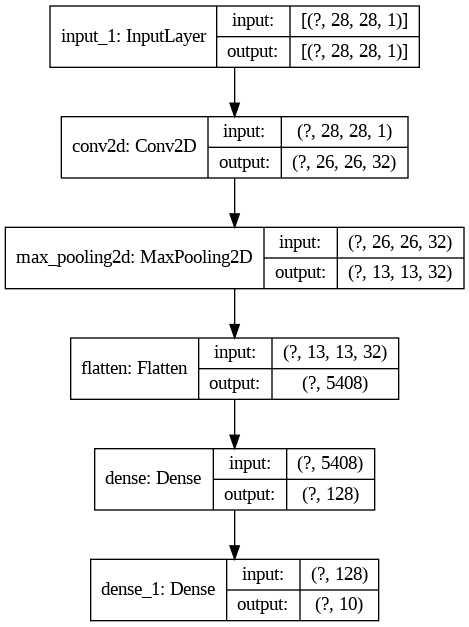

In [5]:
plot_model(model, show_shapes=True)

## Learning

Now let's train the CNN model.

This is a relatively complex model, so training is considerably slower than with MLPs. 

In [6]:
%%time

epochs = 5 # one epoch takes about 45 seconds

history = model.fit(X_train, 
                    Y_train, 
                    epochs=epochs, 
                    batch_size=128,
                    verbose=2)

Epoch 1/5
469/469 - 9s - loss: 0.4607 - accuracy: 0.8372
Epoch 2/5
469/469 - 8s - loss: 0.3111 - accuracy: 0.8901
Epoch 3/5
469/469 - 8s - loss: 0.2674 - accuracy: 0.9046
Epoch 4/5
469/469 - 8s - loss: 0.2397 - accuracy: 0.9140
Epoch 5/5
469/469 - 9s - loss: 0.2157 - accuracy: 0.9219
CPU times: user 3min 24s, sys: 20.2 s, total: 3min 45s
Wall time: 41.8 s


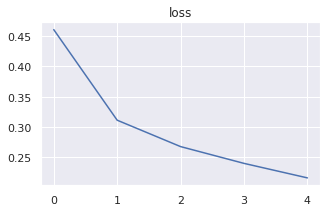

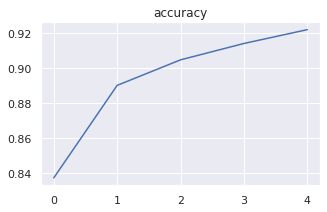

In [7]:
plt.figure(figsize=(5,3))
plt.plot(history.epoch,history.history['loss'])
plt.title('loss')

plt.figure(figsize=(5,3))
plt.plot(history.epoch,history.history['accuracy'])
plt.title('accuracy');

## Inference

With enough training epochs, the test accuracy should exceed 99%.  

You can compare your result with the state-of-the art [here](http://rodrigob.github.io/are_we_there_yet/build/classification_datasets_results.html).  Even more results can be found [here](http://yann.lecun.com/exdb/mnist/). 

In [8]:
%%time
scores = model.evaluate(X_test, Y_test, verbose=2)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

313/313 - 2s - loss: 0.2622 - accuracy: 0.9025
accuracy: 90.25%
CPU times: user 4.98 s, sys: 584 ms, total: 5.56 s
Wall time: 1.86 s


We can now take a closer look at the results using the `show_failures()` helper function.

Here are the first 10 test digits the CNN classified to a wrong class:

Showing max 10 first failures. The predicted class is shown first and the correct class in parenthesis.


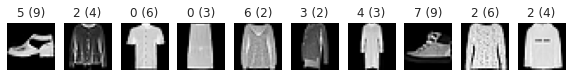

In [9]:
predictions = model.predict(X_test)

show_failures(predictions, y_test, X_test)

We can use `show_failures()` to inspect failures in more detail. For example, here are failures in which the true class was "6":

Showing max 10 first failures. The predicted class is shown first and the correct class in parenthesis.


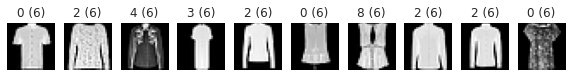

In [10]:
show_failures(predictions, y_test, X_test, trueclass=6)

## Task 1: A more complex CNN model

Your task is to try the same problem as above, but with two convolutional layers. The new model should have the following layers in order:

- Input layer
- Convolutional (`Conv2D`) layer with 32 units and 3x3 kernels, ReLU activation, valid padding
- Another identical convolutional layer
- Max pooling (`MaxPooling2D` layer with 2x2 pooling size
- Dropout with 0.25 rate
- Flatten
- Dense layer with 128 units
- Dropout with 0.5 rate
- Dense output layer (same as in the example above)

You can consult the Keras documentation at https://keras.io/.

The code below is missing the model definition. You can copy any suitable layers from the example above.

In [14]:
ex1_inputs = keras.Input(shape=input_shape)

x = layers.Conv2D(32, (3, 3), activation ='relu', padding='valid')(ex1_inputs)
x = layers.Conv2D(32, (3, 3), activation ='relu', padding='valid')(x)
x = layers.MaxPooling2D(pool_size=(2,2))(x)
x = layers.Dropout(rate=0.25)(x)
x = layers.Flatten()(x)
x = layers.Dense(units=128, activation ='relu')(x)
x = layers.Dropout(rate=0.5)(x)

ex1_outputs = layers.Dense(units=nb_classes, activation='softmax')(x)

Execute cell to see the [example answer](https://raw.githubusercontent.com/csc-training/intro-to-dl/master/day1/solutions/tf2-mnist-cnn-example-answer.py):

In [15]:
# %load solutions/tf2-mnist-cnn-example-answer.py
ex1_inputs = keras.Input(shape=input_shape)

x = layers.Conv2D(32, (3, 3),
                  padding='valid',
                  activation ='relu')(ex1_inputs)
x = layers.Conv2D(32, (3, 3),
                  padding='valid',
                  activation ='relu')(x)
x = layers.MaxPooling2D(pool_size=(2,2))(x)
x = layers.Dropout(0.25)(x)

x = layers.Flatten()(x)
x = layers.Dense(units=128, activation ='relu')(x)
x = layers.Dropout(0.5)(x)

ex1_outputs = layers.Dense(units=nb_classes,
                       activation='softmax')(x)

In [16]:
assert ex1_outputs is not None, "You need to write the missing model definition"

ex1_model = keras.Model(inputs=ex1_inputs, outputs=ex1_outputs,
                        name="better_cnn_model")
ex1_model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
print(ex1_model.summary())

Model: "better_cnn_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 24, 24, 32)        9248      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 12, 12, 32)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 12, 12, 32)        0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 4608)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 128)          

In [17]:
%%time

epochs = 5 # one epoch takes about 45 seconds

ex1_history = ex1_model.fit(X_train, 
                            Y_train, 
                            epochs=epochs, 
                            batch_size=128,
                            verbose=2)

Epoch 1/5
469/469 - 22s - loss: 0.5620 - accuracy: 0.7989
Epoch 2/5
469/469 - 21s - loss: 0.3720 - accuracy: 0.8668
Epoch 3/5
469/469 - 21s - loss: 0.3219 - accuracy: 0.8839
Epoch 4/5
469/469 - 21s - loss: 0.2942 - accuracy: 0.8934
Epoch 5/5
469/469 - 21s - loss: 0.2690 - accuracy: 0.9016
CPU times: user 11min 6s, sys: 24.5 s, total: 11min 30s
Wall time: 1min 47s


Let's plot the data to see how the training progressed. A big gap between training and validation accuracies would suggest overfitting.

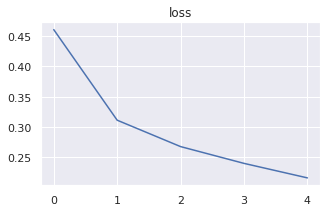

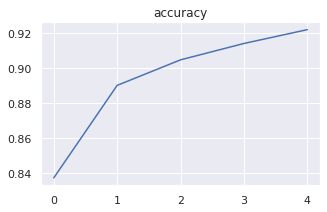

In [18]:
plt.figure(figsize=(5,3))
plt.plot(ex1_history.epoch,history.history['loss'])
plt.title('loss')

plt.figure(figsize=(5,3))
plt.plot(ex1_history.epoch,history.history['accuracy'])
plt.title('accuracy');

In [19]:
ex1_scores = ex1_model.evaluate(X_test, Y_test, verbose=2)
print("%s: %.2f%%" % (ex1_model.metrics_names[1], ex1_scores[1]*100))

313/313 - 2s - loss: 0.2512 - accuracy: 0.9080
accuracy: 90.80%


## Task 2: Tune training parameters

Try to improve the classification accuracy, in particular by trying different optimizers and playing with the parameters of the training process.

See optimizers available in Keras here: <https://keras.io/api/optimizers/#available-optimizers>

The parameters of the `fit()` method are discussed here: <https://keras.io/api/models/model_training_apis/#fit-method>

You can take the model created in Exercise 1 as a starting point. Below is a code example which you can modify.


In [ ]:
""" Model tuning
Model tuning
Note: I have tried to modify:
    - model optimizer: SGD | RMSprop | adam | Adadelta | Adagrad | Adamax | Nadam | Ftrl
    - batch size : 64 | 128 | 256
    - epochs : 5 | 8 | 10
"""

ex2_inputs = keras.Input(shape=input_shape)

# TODO: tweak
x = layers.Conv2D(32, (3, 3), activation ='relu', padding='valid')(ex2_inputs)
x = layers.Conv2D(32, (3, 3), activation ='relu', padding='valid')(x)
x = layers.MaxPooling2D(pool_size=(2,2))(x)
x = layers.Dropout(rate=0.25)(x)
x = layers.Flatten()(x)
x = layers.Dense(units=128, activation ='relu')(x)
x = layers.Dropout(rate=0.5)(x)

ex2_outputs = layers.Dense(units=nb_classes, activation='softmax')(x)

ex2_model = keras.Model(inputs=ex2_inputs, outputs=ex2_outputs,
                        name="custom_model")

ex2_model.compile(loss='categorical_crossentropy', optimizer='Nadam', metrics=['accuracy'])

print(ex2_model.summary())

ex2_history = ex2_model.fit(X_train, Y_train, epochs=10, batch_size=128, verbose=2)

plt.figure(figsize=(5,3))
plt.plot(ex1_history.epoch,history.history['loss'])
plt.title('loss')

plt.figure(figsize=(5,3))
plt.plot(ex1_history.epoch,history.history['accuracy'])
plt.title('accuracy');

ex2_scores = ex2_model.evaluate(X_test, Y_test, verbose=2)
print("%s: %.2f%%" % (ex2_model.metrics_names[1], ex2_scores[1]*100))

Model: "custom_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_16 (InputLayer)        [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_30 (Conv2D)           (None, 24, 24, 32)        9248      
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 12, 12, 32)        0         
_________________________________________________________________
dropout_28 (Dropout)         (None, 12, 12, 32)        0         
_________________________________________________________________
flatten_15 (Flatten)         (None, 4608)              0         
_________________________________________________________________
dense_30 (Dense)             (None, 128)              

---
*Run this notebook in Google Colaboratory using [this link](https://colab.research.google.com/github/csc-training/intro-to-dl/blob/master/day1/03-tf2-mnist-cnn.ipynb).*